In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:02<00:00, 291.07it/s]


# Model Dogs Identification

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [4]:
def ResNet50_model():# create the base pre-trained model
    base_model = ResNet50(weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(dog_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    return model

In [5]:
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 100


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)
tensorborad = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, 
            write_images=False, embeddings_freq=0, embeddings_layer_names=None,
            embeddings_metadata=None, embeddings_data=None)
model = ResNet50_model()



/home/hallab/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 12s 0us/step


In [6]:
model.fit(train_tensors[:100], train_targets[:100],validation_data=(valid_tensors[:100],valid_targets[:100]), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorborad], verbose=2)

Train on 100 samples, validate on 100 samples
Epoch 1/100
 - 3s - loss: 9.0413 - val_loss: 5.2927

Epoch 00001: val_loss improved from inf to 5.29275, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/100
 - 1s - loss: 4.0234 - val_loss: 5.6425

Epoch 00002: val_loss did not improve from 5.29275
Epoch 3/100
 - 1s - loss: 1.7539 - val_loss: 6.0308

Epoch 00003: val_loss did not improve from 5.29275
Epoch 4/100
 - 1s - loss: 0.5934 - val_loss: 5.6911

Epoch 00004: val_loss did not improve from 5.29275
Epoch 5/100
 - 1s - loss: 0.1035 - val_loss: 5.8136

Epoch 00005: val_loss did not improve from 5.29275
Epoch 6/100
 - 1s - loss: 0.0358 - val_loss: 5.9038

Epoch 00006: val_loss did not improve from 5.29275
Epoch 7/100
 - 1s - loss: 0.0193 - val_loss: 5.9367

Epoch 00007: val_loss did not improve from 5.29275
Epoch 8/100
 - 1s - loss: 0.0143 - val_loss: 5.9782

Epoch 00008: val_loss did not improve from 5.29275
Epoch 9/100
 - 1s - loss: 0.0133 - val_loss: 5.9626

Epoch 00

 - 1s - loss: 1.7822e-07 - val_loss: 7.9254

Epoch 00076: val_loss did not improve from 5.29275
Epoch 77/100
 - 1s - loss: 1.6272e-07 - val_loss: 8.0158

Epoch 00077: val_loss did not improve from 5.29275
Epoch 78/100
 - 1s - loss: 1.7822e-07 - val_loss: 8.0549

Epoch 00078: val_loss did not improve from 5.29275
Epoch 79/100
 - 1s - loss: 2.0683e-07 - val_loss: 8.0043

Epoch 00079: val_loss did not improve from 5.29275
Epoch 80/100
 - 1s - loss: 4.4525e-07 - val_loss: 8.0110

Epoch 00080: val_loss did not improve from 5.29275
Epoch 81/100
 - 1s - loss: 0.1432 - val_loss: 9.3157

Epoch 00081: val_loss did not improve from 5.29275
Epoch 82/100
 - 1s - loss: 0.7151 - val_loss: 7.9043

Epoch 00082: val_loss did not improve from 5.29275
Epoch 83/100
 - 1s - loss: 0.3237 - val_loss: 8.0235

Epoch 00083: val_loss did not improve from 5.29275
Epoch 84/100
 - 1s - loss: 0.3224 - val_loss: 8.2950

Epoch 00084: val_loss did not improve from 5.29275
Epoch 85/100
 - 1s - loss: 0.3224 - val_loss: 8.

In [7]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.9569%


### Set trainable value
change the trainable value for the first 130 and retrain the other layer.

In [9]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:130]:
    layer.trainable = False
for layer in model.layers[130:]:
    layer.trainable = True


0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

In [13]:
epochs = 100
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history=model.fit(train_tensors, train_targets,validation_data=(valid_tensors[:100],valid_targets[:100]), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorborad], verbose=2)

Train on 6680 samples, validate on 100 samples
Epoch 1/100
 - 46s - loss: 1.7974 - val_loss: 15.9569

Epoch 00001: val_loss did not improve from 5.29275
Epoch 2/100
 - 43s - loss: 1.2148 - val_loss: 16.1181

Epoch 00002: val_loss did not improve from 5.29275
Epoch 3/100
 - 44s - loss: 0.5322 - val_loss: 4.9475

Epoch 00003: val_loss improved from 5.29275 to 4.94754, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/100
 - 43s - loss: 0.1657 - val_loss: 4.9270

Epoch 00004: val_loss improved from 4.94754 to 4.92697, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/100
 - 43s - loss: 0.1282 - val_loss: 5.0059

Epoch 00005: val_loss did not improve from 4.92697
Epoch 6/100
 - 44s - loss: 0.0990 - val_loss: 5.1727

Epoch 00006: val_loss did not improve from 4.92697
Epoch 7/100
 - 44s - loss: 0.0794 - val_loss: 5.2570

Epoch 00007: val_loss did not improve from 4.92697
Epoch 8/100
 - 43s - loss: 0.0627 - val_loss: 5.0665

Epoch 00008: val_loss did not im

 - 43s - loss: 0.0080 - val_loss: 6.1265

Epoch 00077: val_loss did not improve from 4.92697
Epoch 78/100
 - 42s - loss: 0.0035 - val_loss: 5.5107

Epoch 00078: val_loss did not improve from 4.92697
Epoch 79/100
 - 42s - loss: 0.0044 - val_loss: 5.4826

Epoch 00079: val_loss did not improve from 4.92697
Epoch 80/100
 - 42s - loss: 0.0100 - val_loss: 6.2238

Epoch 00080: val_loss did not improve from 4.92697
Epoch 81/100
 - 42s - loss: 0.0073 - val_loss: 5.6497

Epoch 00081: val_loss did not improve from 4.92697
Epoch 82/100
 - 42s - loss: 0.0074 - val_loss: 5.4784

Epoch 00082: val_loss did not improve from 4.92697
Epoch 83/100
 - 42s - loss: 0.0101 - val_loss: 6.8899

Epoch 00083: val_loss did not improve from 4.92697
Epoch 84/100
 - 42s - loss: 0.0098 - val_loss: 6.0343

Epoch 00084: val_loss did not improve from 4.92697
Epoch 85/100
 - 43s - loss: 0.0063 - val_loss: 5.2592

Epoch 00085: val_loss did not improve from 4.92697
Epoch 86/100
 - 43s - loss: 0.0099 - val_loss: 6.5967

Epoc

dict_keys(['loss', 'val_loss'])


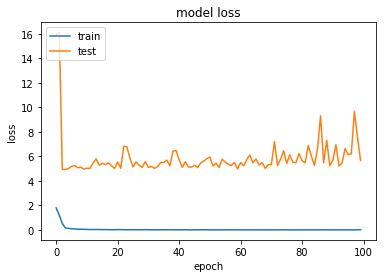

In [19]:
import matplotlib.pyplot as plt                        
%matplotlib inline 

# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.0766%
